# Language Classification with Naive Bayes in Python

## Recommended Prerequisites for Successful Completion
* Intermediate level understanding of Python 3+ (e.g. list and dictionary comprehension)
* Basics of machine learning (e.g. the distinction between training and validation data)
* Mathematical probability (e.g. understanding Bayes' Theorem at a basic level)


## Project Outline
[**Introduction**](#intro)

[**Task 1**](#task1): Exploratory Data Analysis + Visualization

[**Task 2**](#task2): Data Cleaning and Preprocessing

[**Task 3**](#task3): Naive Bayes Model Introduction and Training

[**Task 4**](#task4): Highlighting Problems with Basic Model and Simple Fixes

[**Task 5**](#task5): Advanced Approach to Further Improve Performance

In [1]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
import string

from collections import defaultdict

from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

import joblib
import pickle as pkl

from helper_code import *

<a id='intro'></a>
# Introduction

In [4]:
model=joblib.load('Data/Models/final_model.joblib')
vectorizer=joblib.load('Data/Vectorizers/final_model.joblib')

In [5]:
text = 'okrem iného ako durič na brlohárenie'
text=preprocess_function(text)
text=[split_into_subwords_function(text)]
text_vectorized=vectorizer.transform(text)

model.predict(text_vectorized)

array(['sk'], dtype='<U2')

<a id='task1'></a>
# Task 1: Data Exploration and Visualization

In [6]:
def open_file(filename):
    with open(filename, 'r') as f:
        data = f.readlines()
    return data

In [7]:
data_raw = dict()
data_raw['sk'] = open_file('Data/Sentences/train_sentences.sk')
data_raw['cs'] = open_file('Data/Sentences/train_sentences.cs')
data_raw['en'] = open_file('Data/Sentences/train_sentences.en')

In [8]:
def show_statistics(data):
    for language, sentences in data.items():
        
        number_of_sentences = 0
        number_of_words = 0
        number_of_unique_words = 0
        sample_extract = ''
        
        # take a few minutes to try populate these variables
        
        # here is a hint -- word_list breaks the collections of sentences into a list of words
        word_list = ' '.join(sentences).split()
        number_of_sentences=len(sentences)
        number_of_words=len(word_list)
        number_of_unique_words=len(set(word_list))
        sample_extract=' '.join(sentences[0].split()[0:7])
        
        
        print(f'Language: {language}')
        print('-----------------------')
        print(f'Number of sentences\t:\t {number_of_sentences}')
        print(f'Number of words\t\t:\t {number_of_words}')
        print(f'Number of unique words\t:\t {number_of_unique_words}')
        print(f'Sample extract\t\t:\t {sample_extract}...\n')

In [9]:
show_statistics(data_raw)

Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 2016
Number of unique words	:	 1322
Sample extract		:	 Pán de Grandes Pascual jasne vysvetlil, aká...

Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 158
Number of unique words	:	 141
Sample extract		:	 Upozorňujeme, že jejím cílem je šetřit penězi...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	 2381
Number of unique words	:	 1037
Sample extract		:	 I can understand your approach a little...



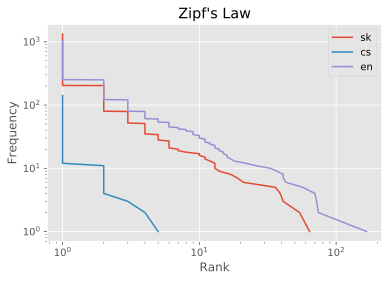

In [10]:
do_law_of_zipf(data_raw)

<a id='task2'></a>
# Task 2: Data Cleaning and Preprocessing

In [17]:
def preprocess(text):
    '''
    Removes punctuation and digits from a string, and converts all characters to lowercase. 
    Also clears all \n and hyphens (splits hyphenated words into two words).
    
    '''
        
    preprocessed_text = text
    
    preprocessed_text=text.lower().replace('-',' ')  
    
    translation_table=str.maketrans('\n',' ',string.punctuation+string.digits)#string.punctutaion+string.digits converted to none therefore nothing written after that
    
    preprocessed_text=preprocessed_text.translate(translation_table)
    
    return preprocessed_text

In [18]:
data_preprocessed={k:[preprocess(sentence) for sentence in v] for k, v in data_raw.items()}

In [19]:
print('raw')
show_statistics(data_raw)

print('\nPreprocessed')
show_statistics(data_preprocessed)

raw
Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 2016
Number of unique words	:	 1322
Sample extract		:	 Pán de Grandes Pascual jasne vysvetlil, aká...

Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 158
Number of unique words	:	 141
Sample extract		:	 Upozorňujeme, že jejím cílem je šetřit penězi...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	 2381
Number of unique words	:	 1037
Sample extract		:	 I can understand your approach a little...


Preprocessed
Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 1996
Number of unique words	:	 1207
Sample extract		:	 pán de grandes pascual jasne vysvetlil aká...

Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 155
Number of unique words	:	 133
Sample extract		:	 upozorňujeme že jejím cílem je šetřit penězi...

Language: en
-----------------------
Number of sentence

<a id='task3'></a>
# Task 3: The Naive Bayes Model

**Bayes' Theorem**

\begin{equation}
P(A | B)=\frac{P(B | A) \times P(A)}{P(B)}
\end{equation}

Now, let's translate this theory into our specific problem. In our case, where we want to categorise a sentence `my name is Ari` into one of `sk`, `cs`, or `en`, the following are the probabilities we want to determine.

\begin{equation}
P(\text {sk} | \text {my name is Ari})=\frac{P(\text {my name is Ari} | \text {sk}) \times P(\text {sk})}{P(\text {my name is Ari})}
\end{equation}

\begin{equation}
P(\text {cs} | \text {my name is Ari})=\frac{P(\text {my name is Ari} | \text {cs}) \times P(\text {cs})}{P(\text {my name is Ari})}
\end{equation}

\begin{equation}
P(\text {en} | \text {my name is Ari})=\frac{P(\text {my name is Ari} | \text {en}) \times P(\text {en})}{P(\text {my name is Ari})}
\end{equation}

## Unseen Data

Since we assume conditional independence across our features, our numerator term for any of the above equations can be broken into the following.

\begin{equation}
P(\text {my name is Ari} | \text {en}) = P(\text {my} | \text {en}) \times P(\text {name} | \text {en}) \times P(\text {is} | \text {en}) \times P(\text {Ari} | \text {en})
\end{equation}

## Vectorizing Training Data

|Sentence   	||   my   	| is 	| I 	| love 	| name 	| it 	| Ari 	|
|-----------------	||:------:	|:--:	|:-:	|:----:	|:----:	|:--------:	|:---:	|
| my name is Ari  	||    1   	|  1 	| 0 	|   0  	|   1  	|     0    	|  1  	|
| I love it 	||    0   	|  0 	| 1 	|   1  	|   0  	|     1    	|  0  	|

In [20]:
sentences_train,y_train=[],[]

for k,v in data_preprocessed.items():
    for sentence in v:
        sentences_train.append(sentence)
        y_train.append(k)

In [21]:
vectorizer=CountVectorizer()

In [23]:
X_train= vectorizer.fit_transform(sentences_train)

In [24]:
X_train

<210x2208 sparse matrix of type '<class 'numpy.int64'>'
	with 3867 stored elements in Compressed Sparse Row format>

## Initializing Model Parameters and Training

In [26]:
naive_classifier=MultinomialNB()#alpha refers to the smoothing constant as otherwise words which were not there in the training model will have probability 0 which will affect the overall prbability of the sentence
naive_classifier.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Vectorizing Validation Data and Evaluating Model

In [27]:
data_val=dict()
data_val['sk']=open_file('Data/Sentences/val_sentences.sk')
data_val['cs']=open_file('Data/Sentences/val_sentences.cs')
data_val['en']=open_file('Data/Sentences/val_sentences.en')
data_val_preprocessed={k:[preprocess(sentence) for sentence in v] for k, v in data_val.items()}

In [28]:
sentences_val,y_val=[],[]

for k, v in data_val_preprocessed.items():
    for sentence in v:
        sentences_val.append(sentence)
        y_val.append(k)

In [29]:
X_val=vectorizer.transform(sentences_val)

In [30]:
predictions=naive_classifier.predict(X_val)

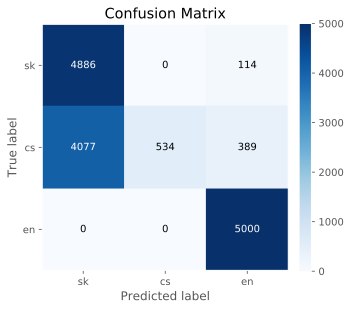

In [31]:
plot_confusion_matrix(y_val,predictions,['sk','cs','en'])

In [32]:
f1_score(y_val,predictions,average='weighted')

0.6149824401040264

<a id='task4'></a>
# Task 4: Simple Adjustments and Highlighting Model Shortcomings

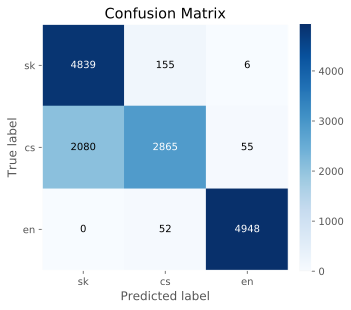

In [33]:
naive_classifier=MultinomialNB(alpha=0.0001,fit_prior=False)#fit_prior=false will give each language an equal probability of occurring
naive_classifier.fit(X_train,y_train)
predictions=naive_classifier.predict(X_val)
plot_confusion_matrix(y_val,predictions,['sk','cs','en'])

In [34]:
f1_score(y_val,predictions,average='weighted')

0.8368507601649364

<a id='task5'></a>
# Task 5: Using Subwords to Shift Perspective

**Dummy Dataset**

playing ; eating ; play ; reads ; tea

**Step 1**

Break each word into characters

playing > p l a y i n g


**Step 2**

Find common character sequences

ea, ing, play

**Step 3**

Convert dataset using these subwords into

play ing ; ea t ing ; play ; r ea d s ; t ea

In [35]:
# taken from https://arxiv.org/abs/1508.07909

import re, collections
def get_stats(vocab):
    pairs = collections.defaultdict(int) 
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq 
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word] 
    return v_out

In [36]:
def get_vocab(data):

    words = []
    for sentence in data:
        words.extend(sentence.split())
        
    vocab = defaultdict(int)
    for word in words:
        vocab[' '.join(word)] += 1
        
    return vocab

In [37]:
vocab = get_vocab(sentences_train)

In [38]:
# also taken from original paper
for i in range(100):
    pairs = get_stats(vocab)
    best = max(pairs, key=pairs.get) 
    vocab = merge_vocab(best, vocab)

In [39]:
merges = defaultdict(int)
for k, v in vocab.items():
    for subword in k.split():
        if len(subword) >= 2:
            merges[subword] += v

In [40]:
merge_ordered = sorted(merges, key=merges.get, reverse=True)

In [41]:
pkl.dump(merge_ordered, open('Data/Auxiliary/merge_ordered.pkl', 'wb'))

In [42]:
def split_into_subwords(text):
    merges = pkl.load(open('Data/Auxiliary/merge_ordered.pkl', 'rb'))
    subwords = []
    for word in text.split():
        for subword in merges:
            subword_count = word.count(subword)
            if subword_count > 0:
                word = word.replace(subword, ' ')
                subwords.extend([subword]*subword_count)
    return ' '.join(subwords)

In [45]:
split_into_subwords('hello my name is swapnil')

'lo na me is il'

In [46]:
data_preprocessed_subwords={k:[split_into_subwords(sentence) for sentence in v] for k,v in data_preprocessed.items()}

In [47]:
show_statistics(data_preprocessed_subwords)

Language: sk
-----------------------
Number of sentences	:	 100
Number of words		:	 3431
Number of unique words	:	 75
Sample extract		:	 de an de al as ne as...

Language: cs
-----------------------
Number of sentences	:	 10
Number of words		:	 239
Number of unique words	:	 59
Sample extract		:	 po je me or že je le...

Language: en
-----------------------
Number of sentences	:	 100
Number of words		:	 3863
Number of unique words	:	 75
Sample extract		:	 an st an er ou ro ch...



In [59]:
data_train_subwords=[]
for sentence in sentences_train:
    data_train_subwords.append(split_into_subwords(sentence))

In [60]:
data_val_subwords=[]
for sentence in sentences_val:
    data_val_subwords.append(split_into_subwords(sentence))

In [61]:
vectorizer=CountVectorizer()

In [62]:
X_train=vectorizer.fit_transform(data_train_subwords)
X_val=vectorizer.transform(data_val_subwords)

In [63]:
naive_classifier=MultinomialNB(alpha=1.0,fit_prior=False)
naive_classifier.fit(X_train,y_train)

predictions=naive_classifier.predict(X_val)

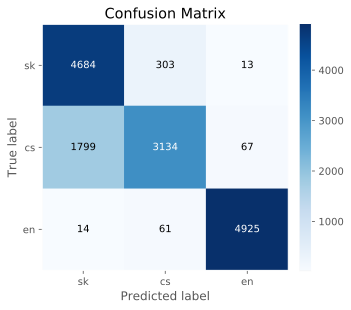

In [64]:
plot_confusion_matrix(y_val,predictions,['sk' ,'cs' ,'en'])

In [65]:
f1_score(y_val,predictions,average='weighted')

0.8456381060126386

In [66]:
joblib.dump(naive_classifier,'Data/Models/final_model.joblib')
joblib.dump(vectorizer,'Data/Vectorizers/final_model.joblib')

['Data/Vectorizers/final_model.joblib']